# Examining Anti-Asian & Pacific Islander Hate Crime in the United States

## Tutorial Content
- Introduction
- Data Collection
- Installing the Libraries
- Downloading and Examining the Data
- EDA
  - Anti-AAPI Hate Crime Density
  - Housing Prices vs. Hate Crime Density
  - Top Hate Crime Locations
  - Top Hate Crime Offenses
  - Age Group vs. Hate Crime Density
- Model to Predict Hate Crime Density
  - Feature Importance
- Summary
- Further Investigation
- References

### Introduction
Over the course of the COVID-19 pandemic, more and more people began noticing a rise in hate crimes against Asian American and Pacific Islander (AAPI) populations. In fact, it's been found that Anti-AAPI hate crimes increased by nearly 150% in 2020 alone. However, it was only in 2021 that this issue began receiving national media attention. The public began realizing the severity of this issue. In the United States, COVID-19 has led to an increase in racism and bigotry against the AAPI community. This can be seen in how many have described the virus as "Kung Flu" and the "China virus", to the thousands of instances of the AAPI community being verbally and physically attacked. 

The importance of this rise in hate crimes is painfully clear. The AAPI community has historically been a marginalized group in the United States, and with the arrival of COVID-19 in this country their mistreatment has only been exacerbated. 

We decided to look at this issue from a historical perspective, examining their mistreatment in the pre-COVID era. 

Looking at this issue, there are several questions that surface:
1. What were anti-AAPI hate crimes like before COVID-19?
2. What factors affect anti-AAPI hate crimes?
3. How do anti-AAPI hate crimes differ by state?

These are the questions this report seeks to answer. Our group investigated anti-AAPI hate crimes in the United States for trends over the years 1991-2019. We assessed the features of housing price index (HPI), poverty, age, sex, and education. These are the factors we looked at to examine their influence on anti-AAPI hate crimes. Furthermore, after our hate crime EDA, we used these features to build a model to predict hate crime density and look at feature importance.

### Data Collection
We used two main sources to collect our data. 

First, we used the FBI hate crime dataset, which has instances of all hate crimes from 1991-2019. We downloaded this CSV file from the FBI website. It includes information such as which state in which the crime occurred, a bias decription of the crime (e.g. "Anti-Jewish"), and the offense type (e.g. "Simple Assault"). Using this dataset, we filtered the biased description variable to "Anti-Asian" to get all instances of anti-AAPI hate crimes from 1991-2019. 

Second, we used the interface of the US Census data website to gather tables about our features. We found tables that had the data we need by state, and downloaded them in CSV format. After collection, we merged these tables into one. For HPI, we used a table downloaded from the Federal Housing Finance Agency.

Our data sources are cited in the "References" section below. 

### Installing the Libraries

In [73]:
# EDA libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from datetime import datetime
from scipy.stats import pearsonr
from statistics import mean
import plotly.express as px

import warnings
warnings.simplefilter("ignore", UserWarning)
pd.options.mode.chained_assignment = None

# modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import ParameterGrid
from tqdm.notebook import tqdm

### Downloading and Examining the Data
We downloaded our data directly from the websites mentioned above. They were then saved and loaded directly using Pandas.

FBI hate crime dataset:

In [74]:
fbi = pd.read_csv("hate_crime.csv", low_memory = False)

fbi.head()

,INCIDENT_ID,DATA_YEAR,ORI,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,REGION_NAME,...,OFFENDER_RACE,OFFENDER_ETHNICITY,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS
0,3015,1991,AR0040200,Rogers,NaN,City,AR,Arkansas,West South Central,South,...,White,NaN,1,Intimidation,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,S,S
1,3016,1991,AR0290100,Hope,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Simple Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S
2,43,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Residence/Home,Anti-Black or African American,Individual,S,S
3,44,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,2,Aggravated Assault;Destruction/Damage/Vandalis...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,M,S
4,3017,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Service/Gas Station,Anti-White,Individual,S,S


These are the instances of hate crimes from 1991-2019. Below, we get the instances that are anti-AAPI hate crimes. We see that we have 6202 of these instances, which we save into a new dataframe called ```asian_df```.

In [11]:
data_df = fbi[['INCIDENT_ID','DATA_YEAR','STATE_ABBR','STATE_NAME','INCIDENT_DATE','TOTAL_OFFENDER_COUNT',
                'OFFENDER_RACE','VICTIM_COUNT','OFFENSE_NAME','LOCATION_NAME','BIAS_DESC','VICTIM_TYPES']].copy()

In [12]:
asian_df = data_df[(data_df['BIAS_DESC'].str.contains('Asian')) | (data_df['BIAS_DESC'].str.contains('Pacific'))]
len(asian_df)

6202

Next, we have a merged dataset of state, year, HPI, number of hate crimes, ratio of females to males, number of asians per km2, percent of the populations that received a high school degree or higher, the percent that received a Bachelor's degree or higher, number of poor divided by number of people per km2, and the densities of different age groups. 

We will call it ```crime_df```. This is a dataframe that combines some of the US Census datasets we used. 

In [75]:
crime_df = pd.read_csv("merged.csv")

crime_df.head()

,State_Abbr,State,Year,HPI,num_crimes,Female_per_male,num_asians_per_km2,Percent HS or higher,Percent Bach or higher,Norm_poor,...,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85+
0,CA,California,1997,422.33,160,1.004704,15,80.7,27.5,338.938144,...,0.076659,0.065129,0.053048,0.039099,0.032330,0.031009,0.027725,0.022444,0.014473,0.011779
1,CA,California,1996,411.04,153,1.003608,15,79.8,26.8,333.041237,...,0.075208,0.065381,0.048843,0.038080,0.032176,0.031768,0.028345,0.021842,0.014328,0.011519
2,CA,California,1995,411.40,142,1.002516,15,79.6,24.2,330.463918,...,0.074288,0.062936,0.048160,0.037492,0.032645,0.032042,0.028801,0.021190,0.014035,0.011254
3,CA,California,1998,456.42,135,1.004670,15,80.1,26.4,343.216495,...,0.077886,0.066335,0.054959,0.041014,0.032967,0.030287,0.027272,0.022656,0.014502,0.011990
4,CA,California,1999,487.38,126,1.006055,15,80.4,27.1,347.474227,...,0.078564,0.067733,0.057324,0.042267,0.033647,0.029422,0.026938,0.022887,0.014715,0.012337


As you can see, each row has information on a state in a specific year. For example, consider the first row, where the variables pertain to California in 1997. 

### EDA

#### Anti-AAPI Hate Crime Density
In our EDA, when we refer to hate crimes we are referring to anti-AAPI hate crimes, unless explicitly stated not so. 

First, we want to get the density of hate crimes as a variable in ```cd``` called "density". We do this by dividing the number of crimes by the number of Asians per km2.

In [76]:
cd = crime_df.set_index(['State_Abbr','State','Year'], inplace=False)
cd = cd[['num_crimes','num_asians_per_km2']]
cd['density'] = cd['num_crimes']/cd['num_asians_per_km2']
cd.head()

num_crimes  num_asians_per_km2    density
State_Abbr State      Year                                           
CA         California 1997         160                  15  10.666667
                      1996         153                  15  10.200000
                      1995         142                  15   9.466667
                      1998         135                  15   9.000000
                      1999         126                  15   8.400000

To create a map of density for all states, we need to aggregate the densities.

In [24]:
density_all_df = (
    cd[['density']]
    .reset_index()
    .groupby(['State_Abbr','State'])
    .agg({'density':'mean'})
)
density_all_df.head()

,,density
State_Abbr,State,
AK,Alaska,0.310345
AL,Alabama,0.103448
AR,Arkansas,0.793103
AZ,Arizona,4.896552
CA,California,3.944828


Now, we can create this map.

In [25]:
fig = px.choropleth(
    density_all_df,
    locationmode='USA-states',
    scope='usa',
    locations=density_all_df.index.get_level_values(0),
    color=density_all_df.density,
    hover_name=density_all_df.index.get_level_values(1),
)

fig.show()

In terms of overall hate crime density, we see that states like Oregon, Colorado, Arizona, Minnesota, and California have higher densities, while much of the Northeast and Southeast regions have lower densities. 

Next, we can look at these densities over time to get a picture of how they've changed in our time frame. We will create the following three subsets of ```density_all_df```:
- ```density_9101_df```: 1991-2001
- ```density_0111_df```:2001-2011
- ```density_1119_df```:2011-2019

Then, we can create maps for these dataframes to compare. 

In [26]:
density_9101_df = (
    cd
    .reset_index()
)
density_9101_df = density_9101_df[density_9101_df['Year'].between(1991,2001)]
density_9101_df = (
    density_9101_df
    .groupby(['State_Abbr','State'])
    .agg({'density':'mean'})
)

density_9101_df.head()

,,density
State_Abbr,State,
AK,Alaska,0.363636
AL,Alabama,0.000000
AR,Arkansas,0.272727
AZ,Arizona,6.636364
CA,California,6.000000


In [27]:
density_0111_df = (
    cd
    .reset_index()
)
density_0111_df = density_0111_df[density_0111_df['Year'].between(2001,2011)]
density_0111_df = (
    density_0111_df
    .groupby(['State_Abbr','State'])
    .agg({'density':'mean'})
)

density_0111_df.head()

,,density
State_Abbr,State,
AK,Alaska,0.272727
AL,Alabama,0.181818
AR,Arkansas,1.727273
AZ,Arizona,4.909091
CA,California,3.503030


In [28]:
density_1119_df = (
    cd
    .reset_index()
)
density_1119_df = density_1119_df[density_1119_df['Year'].between(2011,2019)]
density_1119_df = (
    density_1119_df
    .groupby(['State_Abbr','State'])
    .agg({'density':'mean'})
)

density_1119_df.head()

,,density
State_Abbr,State,
AK,Alaska,0.222222
AL,Alabama,0.222222
AR,Arkansas,0.111111
AZ,Arizona,3.000000
CA,California,2.007407


In [29]:
fig1 = px.choropleth(
    density_9101_df,
    locationmode='USA-states',
    scope='usa',
    locations=density_9101_df.index.get_level_values(0),
    color=density_9101_df.density,
    hover_name=density_9101_df.index.get_level_values(1),
)

fig1.show()

fig2 = px.choropleth(
    density_0111_df,
    locationmode='USA-states',
    scope='usa',
    locations=density_0111_df.index.get_level_values(0),
    color=density_0111_df.density,
    hover_name=density_0111_df.index.get_level_values(1),
)

fig2.show()

fig3 = px.choropleth(
    density_1119_df,
    locationmode='USA-states',
    scope='usa',
    locations=density_1119_df.index.get_level_values(0),
    color=density_1119_df.density,
    hover_name=density_1119_df.index.get_level_values(1),
)

fig3.show()

Here, we see decreasing hate crime density over time. At different points in time, different states have the highest hate crime density. From 1991-2001, this state is Oregon, from 2001-2011, Arizona, and 2011-2019, Michigan.

#### Housing Prices vs. Hate Crime Density
Next, we will use ```crime_df``` to examine the relationship between housing prices (in the form of HPI) and hate crime density.

In [30]:
housing_df = crime_df[['HPI','num_crimes','Year','num_asians_per_km2']]
housing_df = housing_df[housing_df['num_crimes'] != 0]
housing_df['density'] = housing_df['num_crimes']/housing_df['num_asians_per_km2']

housing_df.head()

,HPI,num_crimes,Year,num_asians_per_km2,density
0,422.33,160,1997,15,10.666667
1,411.04,153,1996,15,10.200000
2,411.40,142,1995,15,9.466667
3,456.42,135,1998,15,9.000000
4,487.38,126,1999,15,8.400000


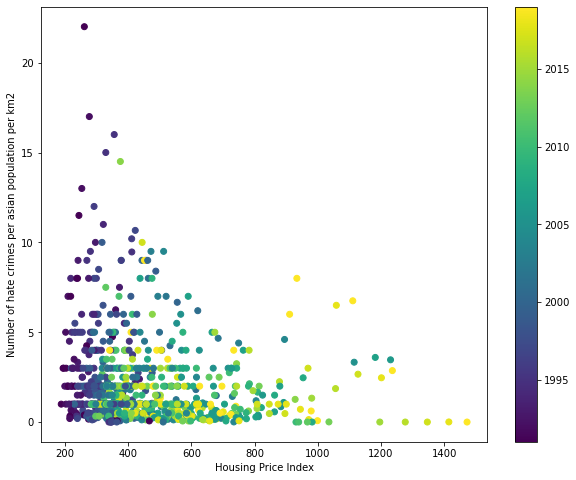

In [31]:
plt.figure(figsize=(10,8))
plt.scatter(
    housing_df['HPI'],
    housing_df['density'],
    c=housing_df['Year'],
)
plt.ylabel('Number of hate crimes per asian population per km2')
plt.xlabel('Housing Price Index')
plt.colorbar()
plt.show()

From this scatterplot, we can see a negative correlation between hate crime density and HPI. As housing prices increase over the years, this hate crime density tends to reduce. 

#### Top Hate Crime Locations
Next, let's investigate the top hate crime locations. First, we look at some of the possible hate crime locations, locations that involve residences, and locations that involve schools. 

In [45]:
data_df['LOCATION_NAME'].unique()[:20]

array(['Highway/Road/Alley/Street/Sidewalk', 'Residence/Home',
       'Service/Gas Station', 'Grocery/Supermarket', 'School/College',
       'Church/Synagogue/Temple/Mosque', 'Other/Unknown',
       'Commercial/Office Building', 'Air/Bus/Train Terminal',
       'Parking/Drop Lot/Garage', 'Hotel/Motel/Etc.', 'Restaurant',
       'Convenience Store', 'Department/Discount Store', 'Bar/Nightclub',
       'Specialty Store', "Drug Store/Doctor's Office/Hospital",
       'Lake/Waterway/Beach', 'Government/Public Building',
       'Jail/Prison/Penitentiary/Corrections Facility'], dtype=object)

In [33]:
residence_offense = [location for location in asian_df['LOCATION_NAME'].unique() if re.search('[Rr]esidence', location)]
residence_offense

['Residence/Home',
 'Residence/Home;School/College',
 'Residence/Home;Restaurant',
 'Parking/Drop Lot/Garage;Residence/Home',
 'Highway/Road/Alley/Street/Sidewalk;Residence/Home',
 'Convenience Store;Residence/Home']

In [34]:
school_offense = [location for location in asian_df['LOCATION_NAME'].unique() if re.search('[Ss]chool|[Cc]ollege|[Uu]niversity|[Pp]rimary|[Ss]econdary', location)]
school_offense

['School/College',
 'Residence/Home;School/College',
 'School-College/University',
 'School-Elementary/Secondary']

Now, we want to look at the locations with the highest number of hate crimes in ```asian_df```.

In [35]:
location_hc = asian_df.groupby('LOCATION_NAME').agg(num_hate_crimes=('INCIDENT_ID','count'))
highest_hc_loc = location_hc[(location_hc['num_hate_crimes']>200)].sort_values('num_hate_crimes', ascending=False).reset_index()
highest_hc_loc

,LOCATION_NAME,num_hate_crimes
0,Residence/Home,2083
1,Highway/Road/Alley/Street/Sidewalk,1131
2,Other/Unknown,492
3,School/College,466
4,Parking/Drop Lot/Garage,390
5,Restaurant,307


Clearly, there are many possible locations. To make the process of examining them easier, we will aggregate similar location names of offenses (e.g. all residence together, all school together, etc.)

In [36]:
school_df = asian_df[(asian_df['LOCATION_NAME'].str.contains('[Ss]chool'))]
res_df = asian_df[(asian_df['LOCATION_NAME'].str.contains('[Rr]esidence|[Hh]ome'))]
highway_df = asian_df[(asian_df['LOCATION_NAME'].str.contains('[Hh]ighway|[Rr]oad|[Ss]treet'))]
parking_df = asian_df[(asian_df['LOCATION_NAME'].str.contains('[Pp]arking'))]
restaurant_df = asian_df[(asian_df['LOCATION_NAME'].str.contains('[Rr]estaurant'))]
other_df = asian_df[(asian_df['LOCATION_NAME'].str.contains('Other'))]

school, res, highway, parking, restaurant = len(school_df), len(res_df), len(highway_df), len(parking_df), len(restaurant_df)

In [39]:
highest_hc_loc['num_hate_crimes'][0,1,3,4,5] = res, highway, school, parking, restaurant
highest_hc_loc['hate_crime_%'] = round(highest_hc_loc['num_hate_crimes']*100/len(asian_df),2)
highest_hc_loc.sort_values('num_hate_crimes', ascending=False,inplace= True)

highest_hc_loc.head()

,LOCATION_NAME,num_hate_crimes,hate_crime_%
0,Residence/Home,2091,33.71
1,Highway/Road/Alley/Street/Sidewalk,1136,18.32
3,School/College,568,9.16
2,Other/Unknown,492,7.93
4,Parking/Drop Lot/Garage,392,6.32


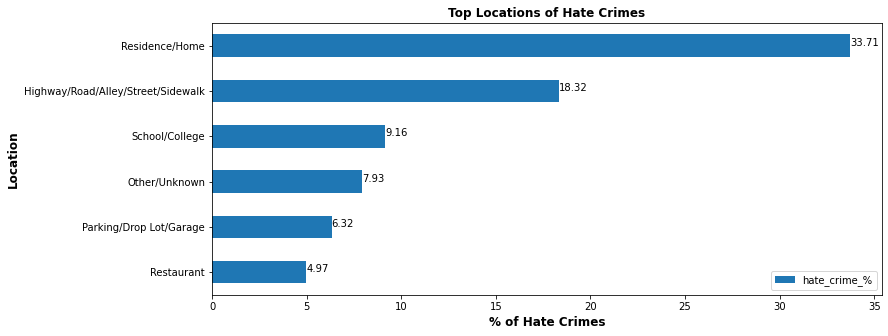

In [40]:
ax = highest_hc_loc.plot.barh(x='LOCATION_NAME', y='hate_crime_%', rot=0, figsize=(12,5))

for i, v in enumerate(highest_hc_loc['hate_crime_%']):
    plt.text(v, i, str(v))
ax.invert_yaxis() 
plt.title('Top Locations of Hate Crimes', weight='bold',  fontsize = 'large')
plt.ylabel('Location', weight='bold', fontsize = 'large')
plt.xlabel('% of Hate Crimes',weight='bold', fontsize = 'large')
plt.show()

Here we observe that residences, street areas, and schools are the top three locations of hate crimes. Residences are by far the top location, where 33.71% of these hate crimes occur. 

To see how this has changed over time, we can plot year by number of hate crimes for the top locations. 

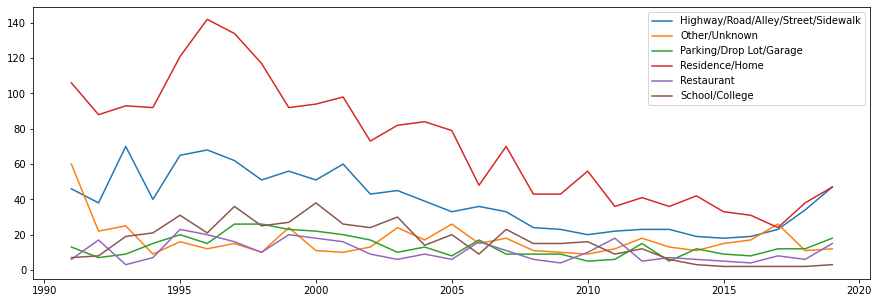

In [42]:
top_loc_names = list(highest_hc_loc['LOCATION_NAME'])

top_loc_df = asian_df.groupby(["LOCATION_NAME", "DATA_YEAR"]).size().reset_index()
top_loc_df.columns = ["location", "year", "num_hate_crimes"]
top_loc_df = top_loc_df[top_loc_df['location'].isin(top_loc_names)]

plt.figure(figsize=(15,5))
for name, group in top_loc_df.groupby("location"):
    plt.plot(group["year"], group["num_hate_crimes"], label = name)
plt.legend()

You can see that hate crimes have generally decreased over time, but there is an increase starting at around 2015. This is especially apparent in hate crimes occurring at residences and at street areas. In fact, the number of hate crimes occurring at street areas catches up with the number at residences as the graph approaches 2019. 

#### Top Hate Crime Offenses
After looking at top hate crime locations, we turn to top hate crime offenses, performing a similar process to get our results. 

In [46]:
data_df['OFFENSE_NAME'].unique()[:20]

array(['Intimidation', 'Simple Assault', 'Aggravated Assault',
       'Aggravated Assault;Destruction/Damage/Vandalism of Property',
       'Robbery',
       'Aggravated Assault;Murder and Nonnegligent Manslaughter',
       'Destruction/Damage/Vandalism of Property',
       'Destruction/Damage/Vandalism of Property;Intimidation',
       'Aggravated Assault;Intimidation',
       'Aggravated Assault;Not Specified', 'Intimidation;Simple Assault',
       'Arson',
       'Destruction/Damage/Vandalism of Property;Intimidation;Simple Assault',
       'Burglary/Breaking & Entering;Destruction/Damage/Vandalism of Property;Not Specified',
       'Murder and Nonnegligent Manslaughter',
       'Intimidation;Not Specified',
       'Destruction/Damage/Vandalism of Property;Not Specified',
       'Burglary/Breaking & Entering',
       'Destruction/Damage/Vandalism of Property;Simple Assault',
       'Not Specified'], dtype=object)

Let's aggregate similar offenses together in the same way we did for locations. 

In [50]:
property_vand_df = asian_df[(asian_df['OFFENSE_NAME'].str.contains('[Pp]roperty|Vandalism'))]
aggr_assault_df = asian_df[(asian_df['OFFENSE_NAME'].str.contains('[Aa]ggravated\s[Aa]ssault'))]
arson_df = asian_df[(asian_df['OFFENSE_NAME'].str.contains('[Aa]rson'))]
burglary_df = asian_df[(asian_df['OFFENSE_NAME'].str.contains('[Bb]urglary'))]
robbery_df = asian_df[(asian_df['OFFENSE_NAME'].str.contains('[Rr]obbery'))]
intim_df = asian_df[(asian_df['OFFENSE_NAME'].str.contains('([In]ntimidation)|[Ss]imple\s[Aa]ssault'))]
larceny_df = asian_df[(asian_df['OFFENSE_NAME'].str.contains('(Larceny)'))]
property_vand, aggr_assault, arson, burglary, robbery, intim,larceny = len(property_vand_df),len(aggr_assault_df),len(arson_df),len(burglary_df),len(robbery_df),len(intim_df), len(larceny_df)

In [51]:
#reassigning the top offenses counts
top_offense_df['num_hate_crimes'][0,1,3,4,6,8,9] = intim, property_vand, aggr_assault, burglary, robbery, larceny, arson
top_offense_df['OFFENSE_NAME'][0]='Intimidation/Simple Assault'

#dropping similar offenses already counted under different label
top_offense_df = top_offense_df.drop(labels=[2,5,7], axis=0)

#converting to percentage
top_offense_df['hate_crime_%'] = round(top_offense_df['num_hate_crimes']*100/len(asian_df),2)
top_offense_df.sort_values('num_hate_crimes', ascending=False,inplace= True)

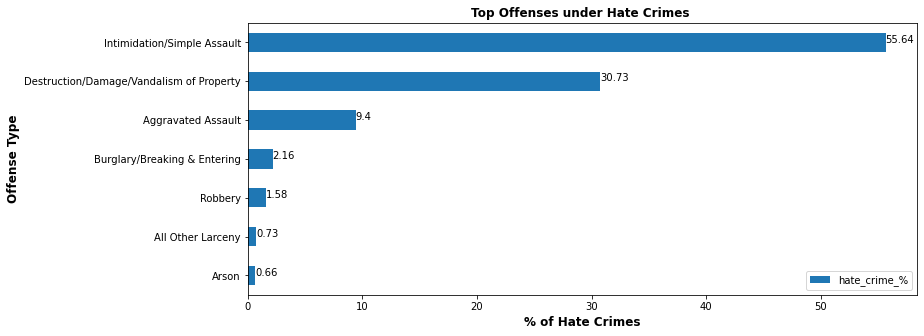

In [53]:
top_off_names = list(top_offense_df['OFFENSE_NAME'][:5])

ax = top_offense_df.plot.barh(x='OFFENSE_NAME', y='hate_crime_%', rot=0, figsize=(12,5))

for i, v in enumerate(top_offense_df['hate_crime_%']):
    plt.text(v, i, str(v))
ax.invert_yaxis() 
plt.title('Top Offenses under Hate Crimes ', weight='bold',  fontsize = 'large')
plt.ylabel('Offense Type', weight='bold', fontsize = 'large')
plt.xlabel('% of Hate Crimes',weight='bold', fontsize = 'large')
plt.show()

Now we have the top types of offenses. Intimidation/simple assault is our top one with 55.64% of hate crimes being committed in this form. Destruction/damage/vandalism of property and aggravated assault are our next two top offenses. 
Let's do the plotting process again to see how they've changed over time. 

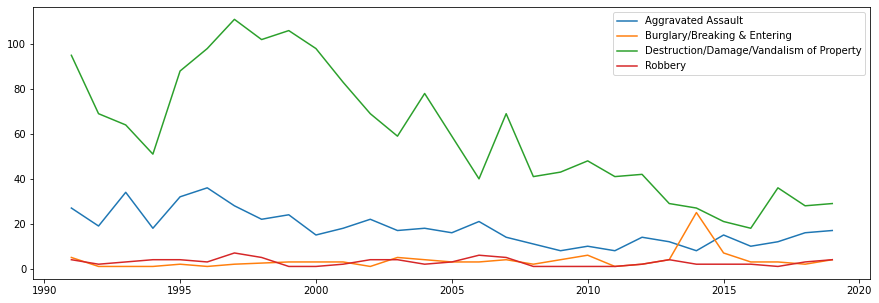

In [55]:
top_off_df = asian_df.groupby(["OFFENSE_NAME", "DATA_YEAR"]).size().reset_index()
top_off_df.columns = ["offense", "year", "num_hate_crimes"]
top_off_df = top_off_df[top_off_df['offense'].isin(top_off_names)]

plt.figure(figsize=(15,5))
for name, group in top_off_df.groupby("offense"):
    plt.plot(group["year"], group["num_hate_crimes"], label = name)
plt.legend()

In a similar fashion to top hate crime locations, we see that offenses have generally decreased over time, but with increases occurring from around the year 2015. 

#### Age Group vs. Hate Crime Density
Age is another factor we wanted to look at when examining anti-AAPI hate crimes. In ```crime_df```, we have densities for different age groups. We can examine the relationship between these and hate crime density. 

First, we will increase age-group range and look at the correlations between age groups and number of hate crimes. 

In [58]:
age_hc_df = pd.DataFrame(crime_df
    [['Year','State_Abbr','num_crimes','1','1-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85+']]
)

age_hc_df.head()

,Year,State_Abbr,num_crimes,1,1-4,5-9,10-14,15-19,20-24,25-29,...,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85+
0,1997,CA,160,0.015278,0.066190,0.082786,0.073945,0.069182,0.066392,0.080371,...,0.076659,0.065129,0.053048,0.039099,0.032330,0.031009,0.027725,0.022444,0.014473,0.011779
1,1996,CA,153,0.015973,0.069498,0.081588,0.074486,0.067713,0.066404,0.081954,...,0.075208,0.065381,0.048843,0.038080,0.032176,0.031768,0.028345,0.021842,0.014328,0.011519
2,1995,CA,142,0.016686,0.071814,0.078687,0.073602,0.065991,0.068845,0.083676,...,0.074288,0.062936,0.048160,0.037492,0.032645,0.032042,0.028801,0.021190,0.014035,0.011254
3,1998,CA,135,0.014793,0.063105,0.082796,0.073790,0.070743,0.067104,0.078752,...,0.077886,0.066335,0.054959,0.041014,0.032967,0.030287,0.027272,0.022656,0.014502,0.011990
4,1999,CA,126,0.014497,0.060494,0.082058,0.074566,0.071737,0.068753,0.076539,...,0.078564,0.067733,0.057324,0.042267,0.033647,0.029422,0.026938,0.022887,0.014715,0.012337


In [59]:
age_hc_rev = pd.DataFrame(age_hc_df[['State_Abbr','num_crimes']])
age_hc_rev['1-19'] = age_hc_df.loc[:,'1':'15-19'].sum(axis=1)
age_hc_rev['20-44'] = age_hc_df.loc[:,'20-24':'40-44'].sum(axis=1)
age_hc_rev['45-69'] = age_hc_df.loc[:,'45-49':'65-69'].sum(axis=1)
age_hc_rev['70-85+'] = age_hc_df.loc[:,'70-74':'85+'].sum(axis=1)

age_hc_rev.head()

,State_Abbr,num_crimes,1-19,20-44,45-69,70-85+
0,CA,160,0.307382,0.395581,0.220616,0.076421
1,CA,153,0.309258,0.398462,0.216246,0.076034
2,CA,142,0.306781,0.404664,0.213275,0.075280
3,CA,135,0.305226,0.392790,0.225563,0.076420
4,CA,126,0.303352,0.389379,0.230392,0.076877


There are two approaches we will use to examine these correlations, heat maps and Pearson correlation. First, we will use the heat map approach. 

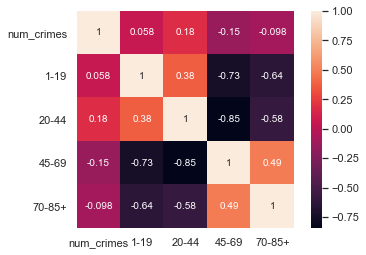

In [60]:
sns.set()
ax = sns.heatmap(age_hc_rev.corr(),square=True, annot=True, annot_kws={'fontsize': 10})
ax.plot()
plt.show()

Here, we see that the age group 20-44 has the highest positive correlation with number of hate crimes, and the age group 45-69 has the highest negative correlation with number of hate crimes. 

Now, we turn to the Pearson correlation approach. We can then create map plots of correlation. 

In [61]:
state_crime_list = []
agegrp_list_0119 = []
agegrp_list_2044 = []
agegrp_list_4569 = []
agegrp_list_7085 = []
for state in age_hc_rev['State_Abbr'].unique():
  state_crime_list.append(list(age_hc_rev.loc[age_hc_rev['State_Abbr'] == state, 'num_crimes']))
  agegrp_list_0119.append(list(age_hc_rev.loc[age_hc_rev['State_Abbr'] == state, '1-19']))
  agegrp_list_2044.append(list(age_hc_rev.loc[age_hc_rev['State_Abbr'] == state, '20-44']))
  agegrp_list_4569.append(list(age_hc_rev.loc[age_hc_rev['State_Abbr'] == state, '45-69']))
  agegrp_list_7085.append(list(age_hc_rev.loc[age_hc_rev['State_Abbr'] == state, '70-85+']))

corr_0119=[] 
corr_2044=[] 
corr_4569=[] 
corr_7085=[]  
for i in range(len(age_hc_rev['State_Abbr'].unique())):
  corr_0119.append(abs(pearsonr(state_crime_list[i], agegrp_list_0119[i])[0]))
  corr_2044.append(abs(pearsonr(state_crime_list[i], agegrp_list_2044[i])[0]))
  corr_4569.append(abs(pearsonr(state_crime_list[i], agegrp_list_4569[i])[0]))
  corr_7085.append(abs(pearsonr(state_crime_list[i], agegrp_list_7085[i])[0]))

C:\Users\sophi\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.



In [62]:
corr_df = pd.DataFrame(crime_df[['State','State_Abbr']])
corr_df=corr_df.drop_duplicates()
corr_df=corr_df.reset_index(drop=True)
corr_df['Corr_Coeff_0019'] = corr_0119
corr_df['Corr_Coeff_2044'] = corr_2044
corr_df['Corr_Coeff_4569'] = corr_4569
corr_df['Corr_Coeff_7085'] = corr_7085

In [63]:
fig1 = px.choropleth(
    corr_df,
    locationmode='USA-states',
    scope='usa',
    locations=corr_df.State_Abbr,
    color=corr_df.Corr_Coeff_0019,
    hover_name=corr_df.State,
)

fig1.show()

fig2 = px.choropleth(
    corr_df,
    locationmode='USA-states',
    scope='usa',
    locations=corr_df.State_Abbr,
    color=corr_df.Corr_Coeff_2044,
    hover_name=corr_df.State,
)

fig2.show()

fig3 = px.choropleth(
    corr_df,
    locationmode='USA-states',
    scope='usa',
    locations=corr_df.State_Abbr,
    color=corr_df.Corr_Coeff_4569,
    hover_name=corr_df.State,
)

fig3.show()

fig4 = px.choropleth(
    corr_df,
    locationmode='USA-states',
    scope='usa',
    locations=corr_df.State_Abbr,
    color=corr_df.Corr_Coeff_7085,
    hover_name=corr_df.State,
)

fig4.show()

Note that Nebraska, with no fill color, has 0 crimes reported from 1991-2019. 

These three maps show the correlations for age groups 1-19, 20-44, and 45-69 with number of hate crimes. From these map plots, we see that the age groups 1-19 and 45-69 have higher correlation with hate crimes in the majority of states. 

### Model to Predict Hate Crime Density
After completing our EDA, we turn to building a model to predict hate crime density using all of the features mentioned before. The first step is, using ```crime_df```, find the r2 scores for each of our possible models. The best possible score is 1.0.

In [78]:
X = crime_df.drop([
                    'State_Abbr',
                    'State',
                    'Year',
                    'num_crimes'
], axis=1).copy()
y = crime_df['num_crimes'].copy()

X.shape, y.shape

((1479, 25), (1479,))

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1035, 25), (444, 25), (1035,), (444,))

In [80]:
model_list = [
              LinearRegression(),
              Ridge(random_state=42),
              KNeighborsRegressor(),
              SVR(),
              RandomForestRegressor(random_state=42),
              GradientBoostingRegressor(random_state=42),
              ExtraTreesRegressor(random_state=42),
              MLPRegressor(random_state=42, max_iter=20000, early_stopping=True)
]
model_names = [
               'Linear Regression',
               'Ridge Regression',
               'KNN',
               'SVR',
               'Random Forest',
               'Gradient Boosting',
               'Extra Trees',
               'MLP'
]

In [81]:
results_df = pd.DataFrame(columns=['model','r2_score'])
for i,model in tqdm(enumerate(model_list)):
  model.fit(X_train, y_train)
  model_results = {
      'model':model_names[i],
      'r2_score':model.score(X_test, y_test)
  }
  results_df = results_df.append(model_results, ignore_index=True)

results_df

,model,r2_score
0,Linear Regression,-0.071643
1,Ridge Regression,-0.019623
2,KNN,0.103936
3,SVR,-0.006048
4,Random Forest,0.748508
5,Gradient Boosting,0.687647
6,Extra Trees,0.769190
7,MLP,0.001032


Extra Trees regressed with an r2 score of 0.769190, the highest score of the models. Therefore, it is the best model for our data. 

#### Feature Importance
Moving on, we can create a plot to look at the feature importance of this model. 

In [82]:
def grid_search(reg, params, X_train, X_test, y_train, y_test):
  best_params = None
  best_score = 0
  for param in tqdm(params):
    model = reg().set_params(**param).fit(X_train, y_train)
    score = model.score(X_test, y_test)
    if score >= best_score:
      best_score = score
      best_params = param
  print('Best score:', best_score)
  print('Best params:', best_params)
  return best_params

In [83]:
rf_params = {
    'n_estimators': [100,150,200],
    'max_depth': [None, 5,7,9],
    'max_features': ['auto','sqrt','log2'],
    'random_state': [42]
}
rf_params = ParameterGrid(rf_params)
rf_best = grid_search(RandomForestRegressor, rf_params, X_train, X_test, y_train, y_test)


Best score: 0.749845142190733
Best params: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 150, 'random_state': 42}


In [84]:
gb_params = {
    'n_estimators': [100,150,200],
    'max_depth': [None, 5,7,9],
    'max_features': ['auto','sqrt','log2'],
    'random_state': [42]
}
gb_params = ParameterGrid(gb_params)
gb_best = grid_search(GradientBoostingRegressor, gb_params, X_train, X_test, y_train, y_test)


Best score: 0.7425320796531949
Best params: {'max_depth': 7, 'max_features': 'log2', 'n_estimators': 100, 'random_state': 42}


In [85]:
et_params = {
    'n_estimators': [100,150,200],
    'max_depth': [None, 5,7,9],
    'max_features': ['auto','sqrt','log2'],
    'random_state': [42]
}
et_params = ParameterGrid(et_params)
et_best = grid_search(ExtraTreesRegressor, et_params, X_train, X_test, y_train, y_test)


Best score: 0.7729759346583902
Best params: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 150, 'random_state': 42}


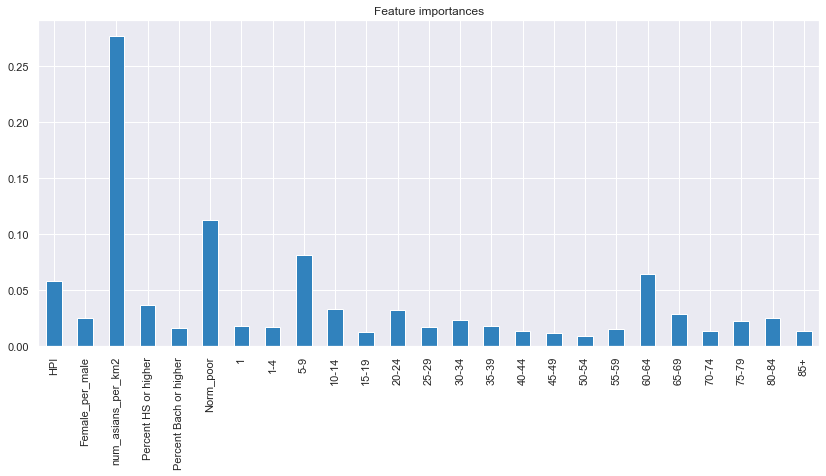

In [86]:
et = ExtraTreesRegressor().set_params(**et_best).fit(X, y)
feat_imp = pd.Series(data=et.feature_importances_, index=X.columns)
feat_imp.plot(kind='bar', colormap='tab20c', figsize=(14,6), title='Feature importances');

Here, we see the model puts emphasis on the factors number of asians per km2, number of poor divided by number of people per km2, and the age groups mentioned before that had higher correlation (1-19 and 45-69). 

### Summary
In our report, we found several results through our EDA. We can return to the three questions we asked in the introduction to see how our findings answered them:

1. What were anti-AAPI hate crimes like before COVID-19?
- Residences, street areas, and schools are the top three locations of hate crimes. 33.71% of hate crimes occurred in residences.
- Intimidation/simple assault, destruction/damage/vandalism of property, and aggravated assault are the top three offense types of hate crimes. 55.64% of hate crimes were in the form of intimidation/simple assault. 
- Hate crimes have generally decreased over time, but there is an increase starting at around 2015. This is evident when looking at both hate crime locations and offenses. 

2. What factors affect anti-AAPI hate crimes?
- In our modeling, we found that Extra Trees was the best model for our data, and that this model placed the most importance on features such as number of asians per km2, number of poor divided by number of people per km2, and the 1-19 and 45-69 age groups.
- As housing prices increase over the years, hate crime density tends to reduce. 
- The age groups 1-19 and 45-69 have higher correlation with hate crimes in the majority of states.

3. How do anti-AAPI hate crimes differ by state?
- In terms of overall hate crime density, we see that states like Oregon, Colorado, Arizona, Minnesota, and California have higher densities, while much of the Northeast and Southeast regions have lower densities.
- We see decreasing hate crime density over time. At different points in time, different states have the highest hate crime density. 

### Further Investigation
There are many different ways to move forward using our findings. 

First, we could use a model to predict whether hate crimes would increase or decrease in different states. This, however, does not include the skewed data from 2020, so it would be a prediction based on if the COVID-19 pandemic hadn't occurred. 

This brings us to the next point, which involves incorporating hate crime data from 2020. Our report is "pre-COVID", so a "post-COVID" section could be made. One factor to consider in this section is vaccine hestiancy by state. In this novel section, one could use factors related to COVID-19 - including vaccine hesitancy - to tangibly see whether they had effect on the increase in hate crimes in 2020. 

Finally, there are other factors we did not include that could also be examined. This includes mental health status, access to mental health resources, access to healthcare, and unemployment rates. 

### References
Datasets we used in this report:
- FBI hate crimes: https://crime-data-explorer.fr.cloud.gov/pages/downloads
  (listed in Master File Downloads under Hate Crime)
- US Census datasets:
    - Age and Sex: https://data.census.gov/cedsci/table?t=Age%20and%20Sex&g=0100000US.04000.001&tid=ACSST1Y2019.S0101
    - Education: https://data.census.gov/cedsci/table?q=Education&t=Educational%20Attainment&g=0100000US.04000.001&tid=ACSST1Y2019.S1501
    - Housing Prices: https://www.fhfa.gov/DataTools/Downloads/Documents/HPI/HPI_AT_BDL_state.xlsx
    - Poverty: https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-poverty-people.html
    (Table 21)

Further resources on Anti-AAPI hate crimes:
- https://stopaapihate.org/
- https://asianamericanstudies.cornell.edu/anti-racism-resources-aapi-community

About the recent rise of Anti-AAPI hate crimes:
- https://www.csusb.edu/sites/default/files/FACT%20SHEET-%20Anti-Asian%20Hate%202020%203.2.21.pdf
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7364747/